In [40]:
import keras
keras.__version__

'2.2.5'

In [0]:
from keras import models
from keras import layers

import numpy as np
import json
import os
import csv
import pandas as pd

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# read json 2-d pose as data, without using: 
#     {15, "REye"},
#     {16, "LEye"},
#     {17, "REar"},
#     {18, "LEar"}

ur_basepath1 = '/content/drive/My Drive/636project/data/fall_UR/fall-cam0'
ur_basepath2 = '/content/drive/My Drive/636project/data/adl_UR'
mc_fall_path = '/content/drive/My Drive/636project/data/MCdataset/mc_fall'
mc_notfall_path = '/content/drive/My Drive/636project/data/MCdataset/mc-notfall'

def input_data(basepath):
  data = []
  entries = os.listdir(basepath)
  for entry in entries:
    path = os.path.join(basepath, entry)
    frames = os.listdir(path)
    for frame in frames:
      frame_path = os.path.join(path, frame)
      with open(frame_path, mode='r') as json_file:
        people_dict = json.load(json_file)
        people = people_dict["people"]
        pose_keypoints_2d = []
        # fill missing data as 0
        if len(people) == 0:
          pose_keypoints_2d = [0] * 63
        else:
          full_pose = people[0].get("pose_keypoints_2d")
          pose_keypoints_2d = full_pose[:45] + full_pose[57:]
         
        pose_keypoints_2d.append(frame.split('.')[0])
        # each pose_keypoints_2d: 
        #    [431.949, 196.241, 0.0564434, 437.194, 187.749, 0.552267,...'fall-06-cam0_000000000065_keypoints']
        # OR [123.949, 283.241, 0.0564434, 437.194, 187.749, 0.552267,...'43_000000000000_keypoints']
        data.append(pose_keypoints_2d)        
  return data

# read the data of UR dataset  
# http://fenix.univ.rzeszow.pl/~mkepski/ds/uf.html
ur_data1 = input_data(ur_basepath1)
print(len(ur_data1))

ur_data2 = input_data(ur_basepath2)
print(len(ur_data2))
 
ur_data = ur_data1 + ur_data2
print("length of UR dataset: ", len(ur_data))

df1 = pd.DataFrame.from_records(ur_data)
df1.to_csv (r'/content/drive/My Drive/636project/ur_data.csv', index = False, header=False)

# read the data of MC dataset
# http://www.iro.umontreal.ca/~labimage/Dataset/
mc_fall_data = input_data(mc_fall_path)
print(len("length of mc-fall dataset: ", mc_fall_data))


df2 = pd.DataFrame.from_records(mc_fall_data)
df2.to_csv(r'/content/drive/My Drive/636project/mc_fall_data.csv', index = False, header=False)

mc_notfall_data = input_data(mc_notfall_path)
print(len("length of mc-not-fall dataset: ", mc_notfall_data))

df3 = pd.DataFrame.from_records(mc_notfall_data)
df3.to_csv(r'/content/drive/My Drive/636project/mc_notfall_data.csv', index = False, header=False)

2995
8941
length of UR dataset 11936
9488
8236


In [43]:
ur_path = '/content/drive/My Drive/636project/ur_data.csv'
mc_fall_path = '/content/drive/My Drive/636project/mc_fall_data.csv'
mc_notfall_path = '/content/drive/My Drive/636project/mc_notfall_data.csv'

# read the video data csv,
# it is faster than running the above code each time
def read_data(path):
  video_data = []
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      video_data.append(row)
  return video_data

ur_data = read_data(ur_path)
mc_fall_data = read_data(mc_fall_path)
mc_notfall_data = read_data(mc_notfall_path)

print(ur_data[0])
print(mc_fall_data[0])
print(mc_notfall_data[0])

['520.972', '128.178', '0.833728', '544.571', '130.782', '0.739747', '540.636', '132.754', '0.726633', '553.086', '154.999', '0.800764', '541.285', '166.155', '0.742877', '549.144', '129.467', '0.745059', '572.703', '155.035', '0.841464', '543.266', '171.369', '0.817947', '572.067', '169.415', '0.607432', '564.874', '166.16', '0.534525', '526.875', '181.191', '0.862423', '554.389', '217.851', '0.612664', '577.962', '170.732', '0.619415', '535.402', '188.398', '0.760066', '560.284', '220.479', '0.65847', '545.882', '232.266', '0.604373', '553.078', '232.915', '0.532739', '566.184', '222.453', '0.655722', '541.939', '229.002', '0.399536', '541.943', '227.687', '0.344383', '560.285', '217.223', '0.153482', 'fall-16-cam0_000000000016_keypoints']
['504.171', '238.019', '0.119379', '481.995', '237.979', '0.647555', '471.564', '247.106', '0.6547', '485.918', '299.334', '0.780827', '525.04', '307.158', '0.770417', '495.036', '228.845', '0.474206', '519.863', '220.995', '0.283234', '539.41', '2

In [44]:
# read target label of UR dataset. 

target = []
path1 = '/content/drive/My Drive/636project/target/urfall-cam0-falls.csv'
path2 = '/content/drive/My Drive/636project/target/urfall-cam0-adls.csv'
# in these csv of UR dataset, 
# '-1' means person is not lying, '1' means person is lying on the ground; '0' is temporary pose, when person "is falling"

def input_fall(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      label = row[2]
      if label == '1' or label == '0':
        record.append(1)        
      else:
        record.append(0)
      # each record: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0] 
      target.append(record)

# though laying in the video, but it is not fall, so I mark 0 as label
def input_adl(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      record.append(0)
      target.append(record)

input_fall(path1)
print("falls of UR dataset", len(target))

input_adl(path2)

df = pd.DataFrame.from_records(target)
df.to_csv (r'/content/drive/My Drive/636project/target_data.csv', index = False, header=False)


falls of UR dataset 2995


In [0]:
# make dictionary of target of ur dataset
target_csv_path = '/content/drive/My Drive/636project/target_data.csv'
idx = 0
idx_dict = {}

with open(target_csv_path, mode='r') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    # each row: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0] 
    idx_dict['.'.join(row[:2])] = idx  # {'fall-17.22' : 112}
    idx += 1

In [46]:
# match body landmark data with label data of ur dataset
bodylandmark = []
label = []

for landmark in ur_data:
  video_name = landmark[-1].split('_')  # 'fall-01-cam0_000000000004'
  a = video_name[0].split('-')
  video_type = a[0] # 'fall'
  video_id = a[1]   # '01'
  frame_id = str(int(video_name[1])) # '000000000004' become '4'
  try:
    a = '.'.join([video_id, frame_id])
    b = '-'.join([video_type, a])
    label.append(target[idx_dict[b]][-1])
    bl = landmark[:-1]
    # convert string into float
    bl = list(map(float,bl))
    bodylandmark.append(bl)
  except:
    continue

print("bodylandmark record sample of ur dataset:" )
print(bodylandmark[0])
print("label of ur dataset: ", len(label))
print("bodylandmark of ur dataset: ", len(bodylandmark))

bodylandmark record sample of ur dataset:
[520.972, 128.178, 0.833728, 544.571, 130.782, 0.739747, 540.636, 132.754, 0.726633, 553.086, 154.999, 0.800764, 541.285, 166.155, 0.742877, 549.144, 129.467, 0.745059, 572.703, 155.035, 0.841464, 543.266, 171.369, 0.817947, 572.067, 169.415, 0.607432, 564.874, 166.16, 0.534525, 526.875, 181.191, 0.862423, 554.389, 217.851, 0.612664, 577.962, 170.732, 0.619415, 535.402, 188.398, 0.760066, 560.284, 220.479, 0.65847, 545.882, 232.266, 0.604373, 553.078, 232.915, 0.532739, 566.184, 222.453, 0.655722, 541.939, 229.002, 0.399536, 541.943, 227.687, 0.344383, 560.285, 217.223, 0.153482]
label of ur dataset:  11475
bodylandmark of ur dataset:  11475


In [0]:
# add data of MC dataset to the whole dataset
# For MC dataset, all frames in fall data should be label 1, 
# and all frames in notfall data should be label 0.
for record in mc_fall_data:
  bl = record[:-1]
  bl = list(map(float,bl))
  bodylandmark.append(bl)
  label.append(1)

for record in mc_notfall_data:
  bl = record[:-1]
  bl = list(map(float,bl))
  bodylandmark.append(bl)
  label.append(0)


In [48]:
# normalize data 
for record in bodylandmark:
  for i in range(0, 63, 3):
    record[i] = float(record[i])/ 640
    record[i + 1] = float(record[i + 1]) / 480

print(bodylandmark[0])
print(len(label))
print(len(bodylandmark))

[0.81401875, 0.2670375, 0.833728, 0.8508921875000001, 0.2724625, 0.739747, 0.8447437499999999, 0.2765708333333333, 0.726633, 0.864196875, 0.32291458333333334, 0.800764, 0.8457578124999999, 0.34615625, 0.742877, 0.8580375, 0.2697229166666667, 0.745059, 0.8948484375, 0.32298958333333333, 0.841464, 0.848853125, 0.35701875, 0.817947, 0.8938546875, 0.35294791666666664, 0.607432, 0.882615625, 0.3461666666666667, 0.534525, 0.8232421875, 0.37748125, 0.862423, 0.8662328125000001, 0.45385625, 0.612664, 0.903065625, 0.3556916666666667, 0.619415, 0.8365656250000001, 0.3924958333333333, 0.760066, 0.87544375, 0.45933125, 0.65847, 0.8529406249999999, 0.48388749999999997, 0.604373, 0.864184375, 0.48523958333333334, 0.532739, 0.8846624999999999, 0.46344375, 0.655722, 0.8467796875, 0.4770875, 0.399536, 0.8467859375, 0.4743479166666667, 0.344383, 0.8754453124999999, 0.4525479166666667, 0.153482]
29199
29199


In [49]:
# make bodylandmark and label to be a same data frame
all_data = []

for i in range(len(bodylandmark)):
  all_data.append([label[i]])
  all_data[i] = all_data[i] + bodylandmark[i]

print(all_data[0])
print(len(all_data))
print(len(all_data[0]))

[0, 0.81401875, 0.2670375, 0.833728, 0.8508921875000001, 0.2724625, 0.739747, 0.8447437499999999, 0.2765708333333333, 0.726633, 0.864196875, 0.32291458333333334, 0.800764, 0.8457578124999999, 0.34615625, 0.742877, 0.8580375, 0.2697229166666667, 0.745059, 0.8948484375, 0.32298958333333333, 0.841464, 0.848853125, 0.35701875, 0.817947, 0.8938546875, 0.35294791666666664, 0.607432, 0.882615625, 0.3461666666666667, 0.534525, 0.8232421875, 0.37748125, 0.862423, 0.8662328125000001, 0.45385625, 0.612664, 0.903065625, 0.3556916666666667, 0.619415, 0.8365656250000001, 0.3924958333333333, 0.760066, 0.87544375, 0.45933125, 0.65847, 0.8529406249999999, 0.48388749999999997, 0.604373, 0.864184375, 0.48523958333333334, 0.532739, 0.8846624999999999, 0.46344375, 0.655722, 0.8467796875, 0.4770875, 0.399536, 0.8467859375, 0.4743479166666667, 0.344383, 0.8754453124999999, 0.4525479166666667, 0.153482]
29199
64


In [50]:
# know the majority and minority
fall = label.count(1)
not_fall = label.count(0)
print(fall)
print(not_fall)

11261
17938


In [51]:
# up-sampling to make the data balance
# Separate majority and minority classes
df = pd.DataFrame.from_records(all_data)
header = ['label']
for i in range(63):
  header.append(i)

df.columns = header
df_majority = df[df.label==0]
df_minority = df[df.label==1]
print("before re-sampling, fall vs not fall: ")
print(df['label'].value_counts())

from sklearn.utils import resample
print("begin to re sample...")
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=17938)    # to match majority class
                                  
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print("after re-sampling...")
# Display new class counts
df_upsampled.label.value_counts()

before re-sampling, fall vs not fall: 
0    17938
1    11261
Name: label, dtype: int64
begin to re sample...
after re-sampling...


1    17938
0    17938
Name: label, dtype: int64

In [52]:
all_data = df_upsampled.values

print(all_data[0])
print(len(all_data[0]))
print("number of all data:", len(all_data))

[0.         0.81401875 0.2670375  0.833728   0.85089219 0.2724625
 0.739747   0.84474375 0.27657083 0.726633   0.86419687 0.32291458
 0.800764   0.84575781 0.34615625 0.742877   0.8580375  0.26972292
 0.745059   0.89484844 0.32298958 0.841464   0.84885312 0.35701875
 0.817947   0.89385469 0.35294792 0.607432   0.88261563 0.34616667
 0.534525   0.82324219 0.37748125 0.862423   0.86623281 0.45385625
 0.612664   0.90306562 0.35569167 0.619415   0.83656563 0.39249583
 0.760066   0.87544375 0.45933125 0.65847    0.85294062 0.4838875
 0.604373   0.86418438 0.48523958 0.532739   0.8846625  0.46344375
 0.655722   0.84677969 0.4770875  0.399536   0.84678594 0.47434792
 0.344383   0.87544531 0.45254792 0.153482  ]
64
number of all data: 35876


In [53]:
# split data into train and test set
np.random.shuffle(all_data)
split_point = len(all_data) // 9
print("split point:", split_point)
test_data = all_data[:split_point]
train_data = all_data[split_point: ]

print("number of test data:", len(test_data))
print("number of train data:",len(train_data))

print(train_data[0])

split point: 3986
number of test data: 3986
number of train data: 31890
[0.         0.47994531 0.36533542 0.91405    0.4799875  0.4088
 0.914333   0.44929844 0.41702292 0.883865   0.43293594 0.4848875
 0.877196   0.43097031 0.55015625 0.876976   0.51247656 0.40338542
 0.927394   0.53297812 0.46042292 0.854528   0.5594125  0.50393542
 0.816151   0.49213281 0.52846458 0.802972   0.46977813 0.5310875
 0.807922   0.47780625 0.59910833 0.839575   0.47982656 0.6643125
 0.87482    0.51051406 0.52834583 0.791414   0.51255781 0.59906875
 0.913026   0.50034531 0.66432917 0.87518    0.51664844 0.68619792
 0.826039   0.52272188 0.68335833 0.841119   0.49620625 0.66712917
 0.807065   0.48204687 0.68600625 0.870046   0.47580625 0.68343333
 0.834456   0.47791875 0.66713333 0.728486  ]


In [39]:
# solution 1: train model using lstm
from tensorflow.keras.layers import LSTM
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from numpy import array
from tensorflow.keras.models import Sequential


def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

x_train = []
y_train = []

for record in train_data:
  x_train.append(record[1:])
  label = int(record[0])
  y_train.append(label) 

x_train = array(x_train)
x_train = x_train.reshape((len(x_train), 1, len(x_train[0])))
print("x_train.shape", x_train.shape)
print(x_train[0])

y_train = array(y_train)
print("y_train.shape", y_train.shape)

# imrpove log: use batch size 16 and add one more lstm layer
model = Sequential()
model.add(LSTM(16, 
               input_shape=(1, 63),
               return_sequences=True))
model.add(LSTM(16, ))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5),
                    callbacks.LearningRateScheduler(scheduler)])

print("finish training")

x_train.shape (31890, 1, 63)
[[0.45145625 0.39521667 0.761139   0.51664844 0.46859375 0.805305
  0.54306562 0.43604167 0.671503   0.         0.         0.
  0.         0.         0.         0.49825313 0.50939375 0.633329
  0.47993281 0.63444792 0.806003   0.4126125  0.67793125 0.792962
  0.52070938 0.61811458 0.411039   0.53293437 0.60727083 0.236312
  0.46572812 0.64530417 0.312318   0.44528906 0.74858125 0.621006
  0.51467031 0.63170625 0.432919   0.5309375  0.71067083 0.610663
  0.59415    0.77303333 0.829398   0.55942656 0.7949625  0.776691
  0.56964844 0.80302917 0.74127    0.61043281 0.77316875 0.748917
  0.39828281 0.74316458 0.601995   0.40035938 0.73774792 0.570832
  0.449375   0.76759583 0.52409   ]]
y_train.shape (31890,)
Epoch 1/100
1595/1595 [==============================] - 12s 8ms/step - loss: 0.4056 - acc: 0.8219 - val_loss: 0.3362 - val_acc: 0.8576 - lr: 0.0010
Epoch 2/100
1595/1595 [==============================] - 12s 7ms/step - loss: 0.2952 - acc: 0.8787 - val_los

In [33]:
# solution 2: train model using CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

x_train = []
y_train = []

for record in train_data:
  x_train.append(record[1:])
  label = int(record[0])
  y_train.append(label) 

x_train = array(x_train)
x_train = x_train.reshape((len(x_train), 3, int(len(x_train[0])/3), 1))

y_train = array(y_train)

#create model
model = Sequential()
model.add(Conv2D(64, 
                 kernel_size=3, 
                 activation='relu', 
                 input_shape=(3,21,1), 
                 padding='same'))
model.add(Conv2D(32, 
                 kernel_size=3, 
                 activation='relu', 
                 padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
# compile and fit
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5),
                    callbacks.LearningRateScheduler(scheduler)])


Epoch 1/100
1595/1595 [==============================] - 8s 5ms/step - loss: 0.2790 - acc: 0.8816 - val_loss: 0.2485 - val_acc: 0.8935 - lr: 0.0010
Epoch 2/100
1595/1595 [==============================] - 7s 5ms/step - loss: 0.1883 - acc: 0.9253 - val_loss: 0.2121 - val_acc: 0.9169 - lr: 0.0010
Epoch 3/100
1595/1595 [==============================] - 7s 5ms/step - loss: 0.1668 - acc: 0.9336 - val_loss: 0.2166 - val_acc: 0.9219 - lr: 0.0010
Epoch 4/100
1595/1595 [==============================] - 8s 5ms/step - loss: 0.1526 - acc: 0.9392 - val_loss: 0.1642 - val_acc: 0.9363 - lr: 0.0010
Epoch 5/100
1595/1595 [==============================] - 7s 5ms/step - loss: 0.1412 - acc: 0.9423 - val_loss: 0.1585 - val_acc: 0.9454 - lr: 0.0010
Epoch 6/100
1595/1595 [==============================] - 7s 5ms/step - loss: 0.1342 - acc: 0.9445 - val_loss: 0.1297 - val_acc: 0.9483 - lr: 0.0010
Epoch 7/100
1595/1595 [==============================] - 7s 5ms/step - loss: 0.1292 - acc: 0.9501 - val_loss: 0.

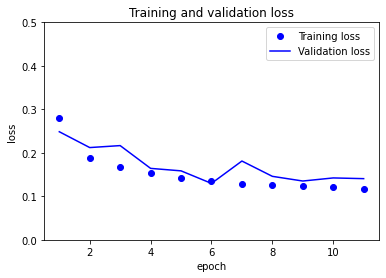

In [34]:
# plotting the results

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch', fontsize=10)
plt.ylabel('loss', fontsize=10)
plt.ylim(0.0,0.5)
plt.legend()

plt.show()

In [0]:
# train the final model on all non-test data avaliable
# for lstm
x_test = []
y_test = []

for record in train_data:
  x_test.append(record[1:])
  label = int(record[0])
  y_test.append(label) 

x_test = array(x_test)
x_test = x_test.reshape((len(x_test), 1, len(x_test[0])))

y_test = array(y_test)

test_score = model.evaluate(x_test, y_test)
print(test_score)

In [36]:
# train the final model on all non-test data avaliable
# for cnn 2d
x_test = []
y_test = []

for record in train_data:
  x_test.append(record[1:])
  label = int(record[0])
  y_test.append(label) 

x_test = array(x_test)
x_test = x_test.reshape((len(x_test), 3, int(len(x_test[0])/3), 1))

y_test = array(y_test)

test_score = model.evaluate(x_test, y_test)
print(test_score)

997/997 [==============================] - 2s 2ms/step - loss: 0.1164 - acc: 0.9559
[0.11636932939291, 0.9558795690536499]


In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 21, 64)         640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 21, 32)         18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 10, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 60,321
Trainable params: 60,321
Non-trainable params: 0
__________________________________________________

In [0]:
model.save("/content/drive/My Drive/636project/model_improve_cnn.h5")